Text(0.5, 1.0, 'USD/CNH Index Value')

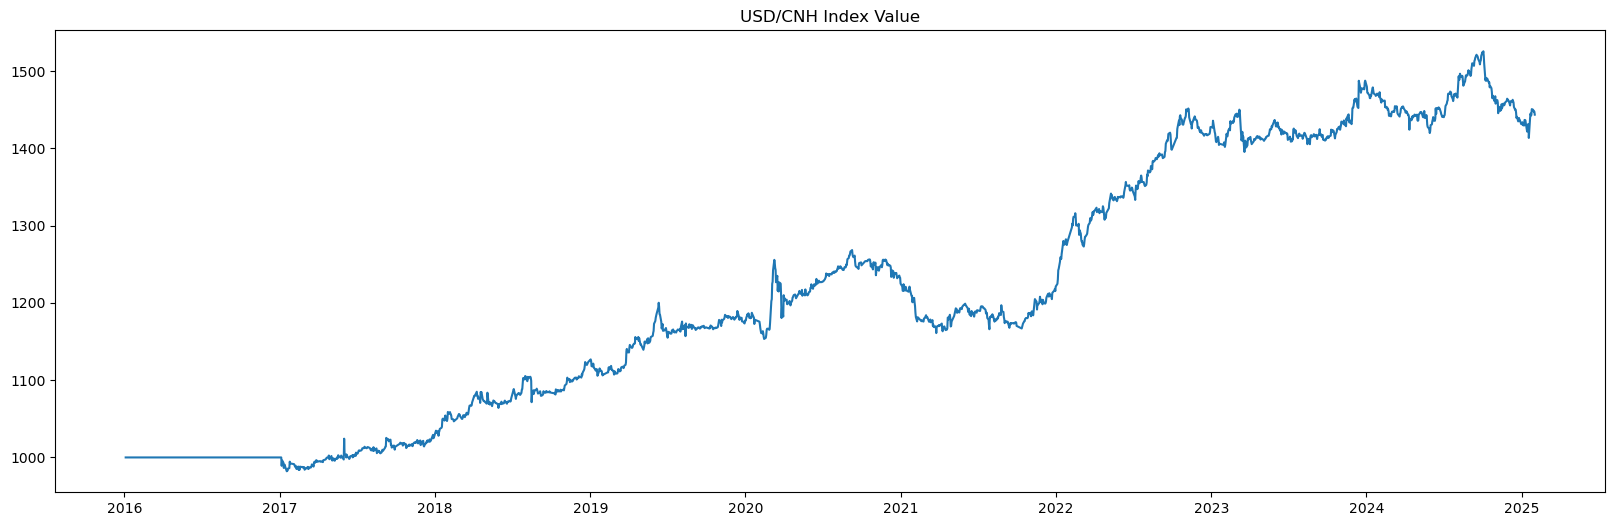

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from datetime import timedelta

df = pd.read_excel('Monthly_data_BBG.xlsx',skiprows=4)
df = df.loc[7:]
df = df.reset_index(drop=True)

def get_currency_strength(df):
    df['CPI_diff'] = df['CNCPIYOY Index'] - df['CPI YOY Index']    # compute CPI diff between China and U.S.
    df.at[0,'EMA'] = df['CPI_diff'].loc[0]
    for i in range(1,len(df)):
        # applying a smoothing factor of 2 with 12-period timeframe for EMA
        df.at[i,'EMA'] = 2/(12+1)*df['CPI_diff'].loc[i] + 11/(12+1)*df['EMA'].loc[i-1]

    df['PMI_diff'] = df['CPMINDX Index'] - df['NAPMPMI Index']    # compute CPI diff between China and U.S.
    df['FX_filter'] = ['RMB' if x > y else 'USD' for x, y in zip(df['CPI_diff'], df['EMA'])]

    df['Yield_diff'] = df['CTCNY10Y Govt'] - df['USGG10YR']       # compute yield diff for 10Y Govt bonds between China and U.S.


    # Layer 1: CPI diff > EMA of CPI diff consecutively for 6M
    df['Layer1'] = ""
    for i in range(6, len(df)):
        if(df['FX_filter'].loc[i-1]==df['FX_filter'].loc[i-2] and df['FX_filter'].loc[i-1]==df['FX_filter'].loc[i-3] and
        df['FX_filter'].loc[i-1]==df['FX_filter'].loc[i-4] and df['FX_filter'].loc[i-1]==df['FX_filter'].loc[i-5] and
        df['FX_filter'].loc[i-1]==df['FX_filter'].loc[i-6]):
            
            df.at[i,'Layer1'] = str(df['FX_filter'].loc[i-1]) + " Strength"
        else:
            df.at[i,'Layer1'] = 'Neutral'


    # Layer 2: CPI diff > 0 consecutively for 6M
    df['Layer2'] = ""
    for i in range(6, len(df)):
        if(df['Layer1'].loc[i]!='Neutral'):
            df.at[i,'Layer2'] = df['Layer1'].loc[i]

        elif(df['CPI_diff'].loc[i-1]>0 and df['CPI_diff'].loc[i-2]>0 and df['CPI_diff'].loc[i-3]>0 and
            df['CPI_diff'].loc[i-4]>0 and df['CPI_diff'].loc[i-5]>0 and df['CPI_diff'].loc[i-6]>0):
            df.at[i,'Layer2'] = "RMB Strength"

        elif(df['CPI_diff'].loc[i-1]<0 and df['CPI_diff'].loc[i-2]<0 and df['CPI_diff'].loc[i-3]<0 and
            df['CPI_diff'].loc[i-4]<0 and df['CPI_diff'].loc[i-5]<0 and df['CPI_diff'].loc[i-6]<0):
            df.at[i,'Layer2'] = "USD Strength"
        
        else:
            df.at[i,'Layer2'] = "Neutral"


    # Layer 3: PMI diff > 0 consecutively for 6M
    df['Layer3'] = ""
    for i in range(6, len(df)):
        if(df['Layer2'].loc[i]!='Neutral'):
            df.at[i,'Layer3'] = df['Layer2'].loc[i]

        elif(df['PMI_diff'].loc[i-1]>0 and df['PMI_diff'].loc[i-2]>0 and df['PMI_diff'].loc[i-3]>0 and
            df['PMI_diff'].loc[i-4]>0 and df['PMI_diff'].loc[i-5]>0 and df['PMI_diff'].loc[i-6]>0):
            df.at[i,'Layer3'] = "RMB Strength"
        
        elif(df['PMI_diff'].loc[i-1]<0 and df['PMI_diff'].loc[i-2]<0 and df['PMI_diff'].loc[i-3]<0 and
            df['PMI_diff'].loc[i-4]<0 and df['PMI_diff'].loc[i-5]<0 and df['PMI_diff'].loc[i-6]<0):
            df.at[i,'Layer3'] = "USD Strength"

        else:
            df.at[i,'Layer3'] = "Neutral"


    # Layer 4: Yield diff is increasing consecutively for 3M
    df['Layer4'] = ""
    for i in range(6, len(df)):
        if(df['Layer3'].loc[i]!='Neutral'):
            df.at[i,'Layer4'] = df['Layer3'].loc[i]
        
        elif(df['Yield_diff'].loc[i-1]>df['Yield_diff'].loc[i-2] and df['Yield_diff'].loc[i-2]>df['Yield_diff'].loc[i-3]):
            df.at[i,'Layer4'] = "RMB Strength"
        
        elif(df['Yield_diff'].loc[i-1]<df['Yield_diff'].loc[i-2] and df['Yield_diff'].loc[i-2]<df['Yield_diff'].loc[i-3]):
            df.at[i,'Layer4'] = "USD Strength"
        
        else:
            df.at[i,'Layer4'] = 'Neutral'
    return df


get_currency_strength(df)
df2 = pd.read_excel('Daily_data_BBG.xlsx',skiprows=3)
df2['Published date'] = pd.to_datetime(df2['Published date']) 

def compute_index(df2):
    # calculate currency strength date for currency strength
    # 3 days into the new months than change the reference month
    df2.at[0:1,'Currency strength date'] = df2['Published date'].loc[0].replace(day=1)
    for i in range(2, len(df2)):
        if(pd.Timestamp(df2['Published date'].loc[i].month)==pd.Timestamp(df2['Published date'].loc[i-1].month) and 
            pd.Timestamp(df2['Published date'].loc[i].month)==pd.Timestamp(df2['Published date'].loc[i-2].month)):
            df2.at[i,'Currency strength date'] = df2['Published date'].loc[i].replace(day=1)
        else:
            df2.at[i,'Currency strength date'] = df2['Currency strength date'].loc[i-1]


    # incorporate currency strength signals from df
    strength = df[['Published date','Layer4']]
    strength = strength.rename(columns={'Published date': 'Currency strength date'})
    df2 = pd.merge(df2, strength, on='Currency strength date', how='inner')


    # get trade direction for 18m foward
    df2['18m forward point'] = ""
    for i in range(1, len(df2)):
        if(df2['Layer4'].loc[i]=='USD Strength'):
            df2.at[i,'18m forward point'] = 'Short'
        elif(df2['Layer4'].loc[i]=='RMB Strength'):
            df2.at[i,'18m forward point'] = 'Long'
        else:
            df2.at[i,'18m forward point'] = df2['18m forward point'].loc[i-1]


    # get trade direction for 6m foward
    df2['6m forward point'] = ""
    for i in range(1, len(df2)):
        if(df2['18m forward point'].loc[i]=='Short'):
            df2.at[i,'6m forward point'] = 'Long'
        elif(df2['18m forward point'].loc[i]=='Long'):
            df2.at[i,'6m forward point'] = 'Short'
        else:
            df2.at[i,'6m forward point'] = ''


    # compute portfolio position (i.e. spread)
    df2['Spread'] = 0.0
    for i in range(0, len(df2)):
        if(df2['18m forward point'].loc[i]=='Short'): 
            df2.at[i,'Spread'] = df2['CNH6M Curncy'].loc[i]-df2['CNH18M Curncy'].loc[i] # 6m - 18m
        elif(df2['18m forward point'].loc[i]=='Long'): 
            df2.at[i,'Spread'] = df2['CNH18M Curncy'].loc[i]-df2['CNH6M Curncy'].loc[i] # 18m - 6m
        else:
            df2.at[i,'Spread'] = 0.0


    # compute daily return %
    df2['Daily return'] = 0.0
    for i in range(1, len(df2)):
        if(df2['6m forward point'].loc[i]==df2['6m forward point'].loc[i-1]):
            df2.at[i,'Daily return'] = ((df2['Spread'].loc[i]-df2['Spread'].loc[i-1])/10000)/df2['USDCNH Curncy'].loc[i-1]
        else:
            df2.at[i,'Daily return'] = 0.0


    # compute exponential weighted volatility, sampled over a 21-day window
    df2['Simple volatility'] = 0.0
    for i in range(20, len(df2)):
        df2.at[i,'Simple volatility'] = df2['Daily return'].loc[i-20:i].std()

    df2['Daily volatility'] = 0.0
    df2.at[20,'Daily volatility'] = df2['Simple volatility'].loc[20]
    sf = 1-(2/(21+1))      # applying a smoothing factor of 2 with 21-period timeframe for exponential weighted vol
    for i in range(21,len(df2)):
        df2.at[i,'Daily volatility'] = np.sqrt(np.power(df2['Daily volatility'].loc[i-1],2)*sf + (1-sf)*np.power(df2['Simple volatility'].loc[i],2))
    df2['Annual volatility'] = df2['Daily volatility']*np.sqrt(252)


    # compute leverage ratio for index, leverage ratio is adjusted monthly during portfolio rebalancing
    # during monthly rebalancing, the annual vol input to compute leverage ratio is lagged by 2-days to reflect
    # T+2 settlement for FX transactions
    df2['Leverage ratio'] = 0.0
    for i in range(3, len(df2)):
        if (df2['Published date'].loc[i].month==df2['Published date'].loc[i-1].month and df2['Published date'].loc[i].month==
            df2['Published date'].loc[i-2].month and df2['Published date'].loc[i-2].month!=df2['Published date'].loc[i-3].month):
            with np.errstate(divide='ignore'):  # ignore error where Annual vol is 0
                df2.at[i,'Leverage ratio'] = min(0.05/df2['Annual volatility'].loc[i-2], 15)
        else:
            df2.at[i,'Leverage ratio'] = df2['Leverage ratio'].loc[i-1]


    # compute portfolio notional, daily portfolio pnl, and daily index value
    # set initial portoflio notional as 0, daily portfolio pnl as 0, beginning index value as 1000 on Jan 3rd, 2017
    df2['Notional'] = 0.0
    df2['Profit and loss'] = 0.0
    df2['Index value'] = 1000.0 

    index_startdate = df2[df2['Published date']=='2017-01-03 00:00:00'].index[0]
    for i in range(index_startdate+2,len(df2)):
        # compute portfolio notional
        if (df2['Published date'].loc[i].month==df2['Published date'].loc[i-1].month and df2['Published date'].loc[i].month==
            df2['Published date'].loc[i-2].month and df2['Published date'].loc[i-2].month!=df2['Published date'].loc[i-3].month):
            df2.at[i,'Notional'] = df2['Index value'].loc[i-2]*df2['Leverage ratio'].loc[i]
        else:
            df2.at[i,'Notional'] = df2['Notional'].loc[i-1]
        
        # compute daily portfolio pnl
        if (df2['6m forward point'].loc[i]==df2['6m forward point'].loc[i-1]):
            df2.at[i,'Profit and loss']=(df2['Spread'].loc[i]-df2['Spread'].loc[i-1])/10000*(
                df2['Notional'].loc[i]/df2['USDCNH Curncy'].loc[i-1])
        else:
            df2.at[i,'Profit and loss'] = 0.0
        
        # compute index value
        df2.at[i,'Index value'] = df2['Index value'].loc[i-1] + df2['Profit and loss'].loc[i]
    
    return df2


# type((df2['Published date'].loc[9]-df2['Published date'].loc[8])/timedelta(days=1))


df2 = compute_index(df2)
# Plot index
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(df2['Published date'], df2['Index value'])
plt.title('USD/CNH Index Value')


Text(0.5, 1.0, 'USD/CNH Index Annualized Volatility')

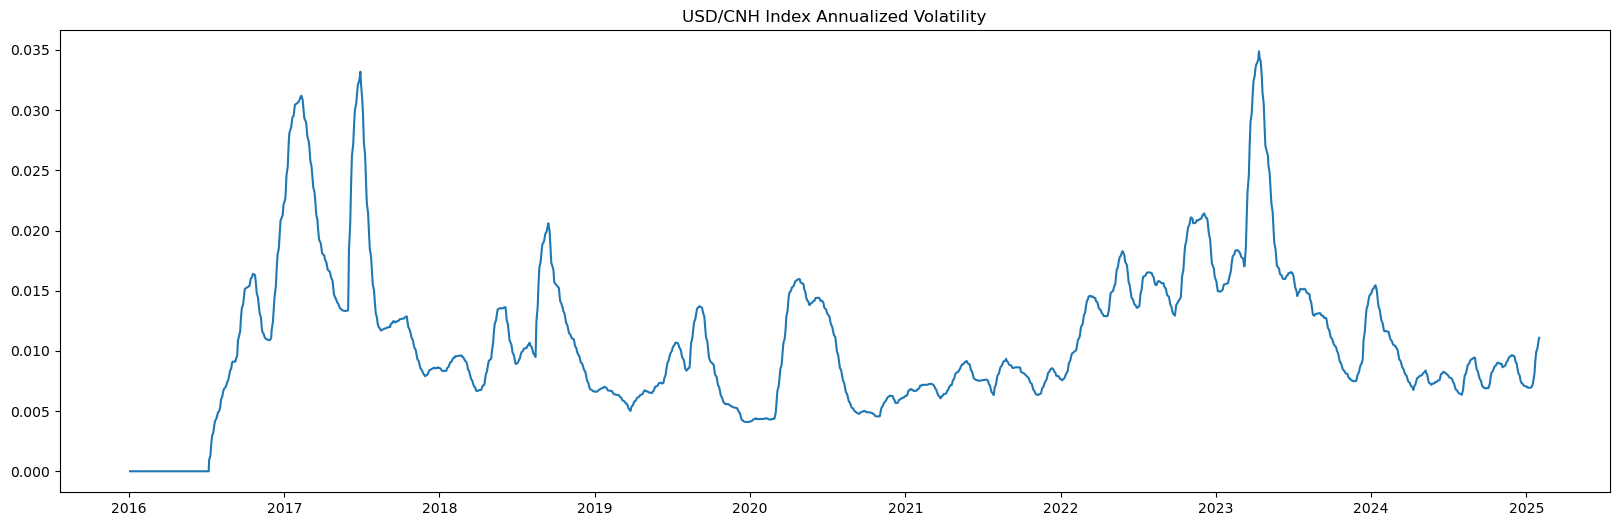

In [5]:
# Plot annualized volatility
fig_vol, ax_vol = plt.subplots(figsize=(20,6))
ax_vol.plot(df2['Published date'], df2['Annual volatility'])
plt.title('USD/CNH Index Annualized Volatility')

Text(0.5, 1.0, 'USD/CNH Index Daily return')

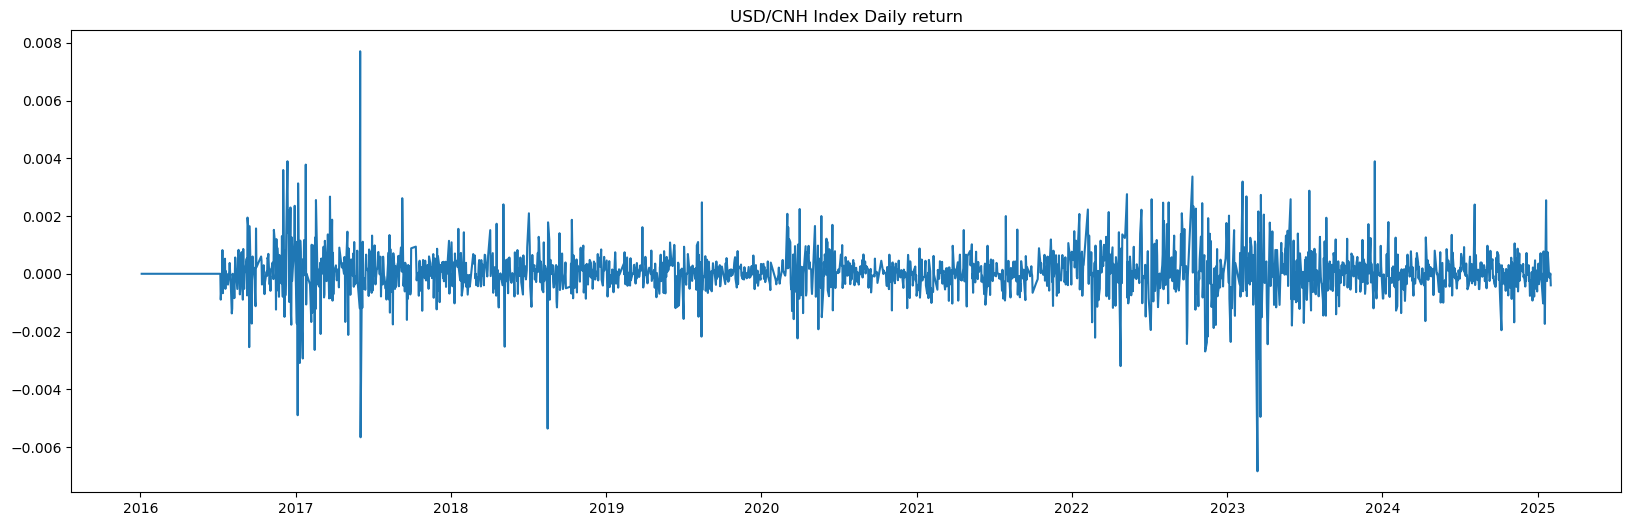

In [6]:
# Plot daily return
fig_ret, ax_ret = plt.subplots(figsize=(20,6))
ax_ret.plot(df2['Published date'], df2['Daily return'])
plt.title('USD/CNH Index Daily return')